## Import all modules

In [1]:
import pandas as pd # to start reading csv
import numpy as np
import matplotlib.pyplot as plt #plotting basic
import seaborn as sns
%matplotlib inline

## Reading all the files

In [2]:
aisles = pd.read_csv("aisles.csv")
departments = pd.read_csv("departments.csv")
order_products_prior = pd.read_csv("order_products__prior.csv")
order_products_train = pd.read_csv("order_products__train.csv")
orders = pd.read_csv("orders.csv")
products = pd.read_csv("products.csv")

In [3]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


## Opening the Training data

filtering the orders dataset to only include training data and prior to only include prior data respectively

In [4]:
train_orders=orders[orders['eval_set']=='train']
trains=pd.merge(order_products_train, train_orders,how='left', on='order_id')
trains.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,49302,1,1,112108,train,4,4,10,9.0
1,1,11109,2,1,112108,train,4,4,10,9.0
2,1,10246,3,0,112108,train,4,4,10,9.0
3,1,49683,4,0,112108,train,4,4,10,9.0
4,1,43633,5,1,112108,train,4,4,10,9.0


In [5]:
prior_orders=orders[orders['eval_set']=='prior']
priors = pd.merge(order_products_prior, prior_orders, on='order_id',how ='right')
priors.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0


# Section A: Feature Extraction

This step will focus on three main feature categories; product features, user features and user-product features

## Feature Engineering Part I: Product Features

- purchase_count: How many people purchased this product
- reordered_count: How many people reordered this product

In [6]:
priors_product = pd.merge(priors, products, on='product_id')
priors_product.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16
1,26,33120,5,0,153404,prior,2,0,16,7.0,Organic Egg Whites,86,16
2,120,33120,13,0,23750,prior,11,6,8,10.0,Organic Egg Whites,86,16
3,327,33120,5,1,58707,prior,21,6,9,8.0,Organic Egg Whites,86,16
4,390,33120,28,1,166654,prior,48,0,12,9.0,Organic Egg Whites,86,16


In [7]:
priors_product_purchase= priors_product.groupby(["product_id"]).size().reset_index(name ='purchase_count')
priors_product_purchase.head()

,product_id,purchase_count
0,1,1852
1,2,90
2,3,277
3,4,329
4,5,15


In [8]:
priors_reordered = priors_product[priors_product['reordered'] == 1]
priors_reordered.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16
3,327,33120,5,1,58707,prior,21,6,9,8.0,Organic Egg Whites,86,16
4,390,33120,28,1,166654,prior,48,0,12,9.0,Organic Egg Whites,86,16
5,537,33120,2,1,180135,prior,15,2,8,3.0,Organic Egg Whites,86,16
6,582,33120,7,1,193223,prior,6,2,19,10.0,Organic Egg Whites,86,16


In [9]:
priors_product_reordered= priors_reordered.groupby(["product_id"]).size().reset_index(name ='reordered_count')
priors_product_reordered.head()

,product_id,reordered_count
0,1,1136
1,2,12
2,3,203
3,4,147
4,5,9


In [10]:
prods=pd.merge(priors_product_purchase,priors_product_reordered, on='product_id')
prods['prod_reorder_rate']=prods['reordered_count']/prods['purchase_count']
prods.head()

,product_id,purchase_count,reordered_count,prod_reorder_rate
0,1,1852,1136,0.613391
1,2,90,12,0.133333
2,3,277,203,0.732852
3,4,329,147,0.446809
4,5,15,9,0.600000


## Feature Engineering Part 2: User Features

- average number of days the user comes back from shopping
- average size of user cart
- total order per user

In [11]:
avg_reorder_days = prior_orders.groupby(["user_id"])['days_since_prior_order'].aggregate('count').reset_index(name='avg_days_prior_order')
avg_reorder_days.head()

,user_id,avg_days_prior_order
0,1,9
1,2,13
2,3,11
3,4,4
4,5,3


In [12]:
avg_usercart_size = priors_reordered.groupby(["user_id"])['add_to_cart_order'].aggregate('count').reset_index(name='avg_user_cart_size')
avg_usercart_size.head()

,user_id,avg_user_cart_size
0,1,41
1,2,93
2,3,55
3,4,1
4,5,14


In [13]:
total_order_per_user = prior_orders.groupby('user_id').size().reset_index(name='total_order_per_user')
total_order_per_user.head()

,user_id,total_order_per_user
0,1,10
1,2,14
2,3,12
3,4,5
4,5,4


In [14]:
users= pd.merge(avg_reorder_days,avg_usercart_size)
users_fin=pd.merge(users,total_order_per_user)
users_fin.head()

,user_id,avg_days_prior_order,avg_user_cart_size,total_order_per_user
0,1,9,41,10
1,2,13,93,14
2,3,11,55,12
3,4,4,1,5
4,5,3,14,4


# Feature Engineering Part 3: Product User features

- how many times this specific user buy this product
- reorder rate of this product by the user: reorder rate = product reordered by this customer/number of order by this customer

In [15]:
priors_product_purchase_spec= priors_product.groupby(["user_id","product_id"]).size().reset_index(name ='purchase_count_spec')
priors_product_purchase_spec['userprod_id']=priors_product_purchase_spec['product_id'] + priors_product_purchase_spec['user_id'] *100000
priors_product_purchase_spec.head(10)

,user_id,product_id,purchase_count_spec,userprod_id
0,1,196,10,100196
1,1,10258,9,110258
2,1,10326,1,110326
3,1,12427,10,112427
4,1,13032,3,113032
5,1,13176,2,113176
6,1,14084,1,114084
7,1,17122,1,117122
8,1,25133,8,125133
9,1,26088,2,126088


In [16]:
#mistake here to just use priors_reordered for reorder =1 which makes all data reorder =1 only
priors_product_reordered_spec= priors_reordered.groupby(["user_id","product_id"]).size().reset_index(name ='reordered_count_spec')
priors_product_reordered_spec['userprod_id']=priors_product_reordered_spec['product_id'] + priors_product_reordered_spec['user_id'] *100000
priors_product_reordered_spec.head(10)

,user_id,product_id,reordered_count_spec,userprod_id
0,1,196,9,100196
1,1,10258,8,110258
2,1,12427,9,112427
3,1,13032,2,113032
4,1,13176,1,113176
5,1,25133,7,125133
6,1,26088,1,126088
7,1,26405,1,126405
8,1,46149,2,146149
9,1,49235,1,149235


In [17]:
prods_user =pd.merge(priors_product_purchase_spec,priors_product_reordered_spec, on="userprod_id",how="outer")
prods_user['reorder_ratio']=prods_user['reordered_count_spec']/prods_user['purchase_count_spec']
prods_user.head()

,user_id_x,product_id_x,purchase_count_spec,userprod_id,user_id_y,product_id_y,reordered_count_spec,reorder_ratio
0,1,196,10,100196,1.0,196.0,9.0,0.900000
1,1,10258,9,110258,1.0,10258.0,8.0,0.888889
2,1,10326,1,110326,NaN,NaN,NaN,NaN
3,1,12427,10,112427,1.0,12427.0,9.0,0.900000
4,1,13032,3,113032,1.0,13032.0,2.0,0.666667


In [18]:
#columns=['user_id_x','product_id_x','user_id_y','product_id_y']
#prods_user.drop(columns, inplace=True, axis=1)
#prods_user.rename(columns={'user_id_x': 'user_id', 'product_id_x': 'product_id'}, inplace=True)

In [19]:
#prods_user=prods_user.fillna(0)
#prods_user.head()

,purchase_count_spec,userprod_id,reordered_count_spec,reorder_ratio
0,10,100196,9.0,0.900000
1,9,110258,8.0,0.888889
2,1,110326,0.0,0.000000
3,10,112427,9.0,0.900000
4,3,113032,2.0,0.666667


# Section B: Merging All prior data to train data
- merging train data with F.E 1, product id
- merging the product of the merged data with F.E 2, user id
- merging the product of the merged data with F.E 3, product id, user id

- Note that we should have 8-12 features up until here

In [20]:
trains_fe= pd.merge(trains, prods, on='product_id')
trains_fe.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,purchase_count,reordered_count,prod_reorder_rate
0,1,49302,1,1,112108,train,4,4,10,9.0,163,101,0.619632
1,816049,49302,7,1,47901,train,14,4,6,16.0,163,101,0.619632
2,1242203,49302,1,1,2993,train,15,0,7,7.0,163,101,0.619632
3,1383349,49302,11,1,41425,train,4,3,8,14.0,163,101,0.619632
4,1787378,49302,8,0,187205,train,5,4,14,30.0,163,101,0.619632


In [21]:
trains_fe1=pd.merge(trains_fe,users_fin)
trains_fe1.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,purchase_count,reordered_count,prod_reorder_rate,avg_days_prior_order,avg_user_cart_size,total_order_per_user
0,1,49302,1,1,112108,train,4,4,10,9.0,163,101,0.619632,2,9,3
1,1,11109,2,1,112108,train,4,4,10,9.0,4472,3192,0.713775,2,9,3
2,1,10246,3,0,112108,train,4,4,10,9.0,23826,12498,0.524553,2,9,3
3,1,49683,4,0,112108,train,4,4,10,9.0,97315,67313,0.691702,2,9,3
4,1,43633,5,1,112108,train,4,4,10,9.0,653,312,0.477795,2,9,3


## Training and Testing data to prepare for input to prediction model

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score,f1_score
from sklearn.metrics import confusion_matrix
from sklearn.grid_search import GridSearchCV


/Users/Gary/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/Gary/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Deciding the Predictor and Target Variables

In [24]:
#features
trains_fe2_x= trains_fe1.drop(['days_since_prior_order','add_to_cart_order','reordered','eval_set'], axis=1)
trains_fe2_x.head() #12 features as the predictor variables

,order_id,product_id,user_id,order_number,order_dow,order_hour_of_day,purchase_count,reordered_count,prod_reorder_rate,avg_days_prior_order,avg_user_cart_size,total_order_per_user
0,1,49302,112108,4,4,10,163,101,0.619632,2,9,3
1,1,11109,112108,4,4,10,4472,3192,0.713775,2,9,3
2,1,10246,112108,4,4,10,23826,12498,0.524553,2,9,3
3,1,49683,112108,4,4,10,97315,67313,0.691702,2,9,3
4,1,43633,112108,4,4,10,653,312,0.477795,2,9,3


In [25]:
#target
trains_fe2_y= trains_fe1[['reordered']]
trains_fe2_y.head()

,reordered
0,1
1,1
2,0
3,0
4,1


In [26]:
# before train test split, split into x_train and y_train
X_train, X_test, y_train, y_test = train_test_split(trains_fe2_x, trains_fe2_y, test_size=0.2)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(830500, 12)
(830500, 1)
(207626, 12)
(207626, 1)


# Section C: Applying training and testing dataset to predictive model

## Model 1 (Main) Logistic Regression

In [27]:
logreg = LogisticRegression()
logreg.fit(X_train,y_train)

/Users/Gary/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [28]:
y_pred_lgr =logreg.predict(X_test)
y_train_pred_lgr=logreg.predict(X_train)
print("Accuracy of logistic regression classifier on on test set: {:0.5f}".format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on on test set: 0.65549


Next, cross validation is run to avoid overfitting while producing a prediction on each feature. Let's apply a 10-fold to train out logistic regression model

In [29]:
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
kfold =model_selection.KFold(n_splits=10, random_state=7)
modelCV =LogisticRegression()
scoring ='accuracy'
results =model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring='accuracy')
print ("10-fold cross validation average accuracy: %.3f" %(results.mean()))

10-fold cross validation average accuracy: 0.652


If the average accuracy remains very close to the model accuracy, we can conclude the model generalizes well.

In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_lgr))

             precision    recall  f1-score   support

          0       0.62      0.35      0.45     82860
          1       0.67      0.86      0.75    124766

avg / total       0.65      0.66      0.63    207626



In [32]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred_lgr)
print(confusion_matrix)

[[ 29237  53623]
 [ 17906 106860]]


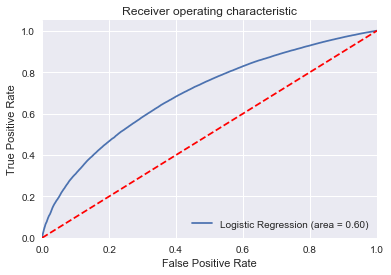

In [33]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [34]:
# Compute and print R^2 and RMSE
from sklearn.metrics import mean_squared_error
print("R^2: {}".format(logreg.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test,y_pred_lgr))
print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.655491123462
Root Mean Squared Error: 0.586948785277


In [35]:
#computing the f1 score
from sklearn.metrics import f1_score
f1_score(y_test, y_pred_lgr, average='macro')  

0.5995148789017779

In [36]:
roc_auc_score(y_test, y_pred_lgr)

0.60466575722777416

# Section D: Trying other models
- Decision trees
- Random Forest
- LightGBM Models

## Model 2: Decision Trees

In [37]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(random_state = 100,
                               max_depth=3, min_samples_leaf=5)
clf.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

In [38]:
y_pred_clf =clf.predict(X_test)
y_train_pred_clf=clf.predict(X_train)
print("Accuracy of logistic regression classifier on on test set: {:0.5f}".format(clf.score(X_test, y_test)))

Accuracy of logistic regression classifier on on test set: 0.68691


In [39]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_clf))

             precision    recall  f1-score   support

          0       0.63      0.52      0.57     82860
          1       0.71      0.80      0.75    124766

avg / total       0.68      0.69      0.68    207626



In [40]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred_clf)
print(confusion_matrix)

[[43125 39735]
 [25270 99496]]


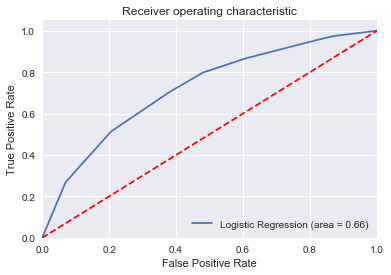

In [41]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [42]:
roc_auc_score(y_test, y_pred_clf)

0.6589585189354269

## Model 3: Random Forest Classification

In [43]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 10, random_state = 42)
# Train the model on training data
rf.fit(X_train,y_train)

/Users/Gary/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [44]:
# Use the forest's predict method on the test data
y_pred_rf = rf.predict(X_test)
y_train_pred_rf=rf.predict(X_train)
print("Accuracy of logistic regression classifier on on test set: {:0.5f}".format(rf.score(X_test, y_test)))

Accuracy of logistic regression classifier on on test set: 0.66588


In [45]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_rf))

             precision    recall  f1-score   support

          0       0.58      0.60      0.59     82860
          1       0.73      0.71      0.72    124766

avg / total       0.67      0.67      0.67    207626



In [46]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred_rf)
print(confusion_matrix)

[[49599 33261]
 [36111 88655]]


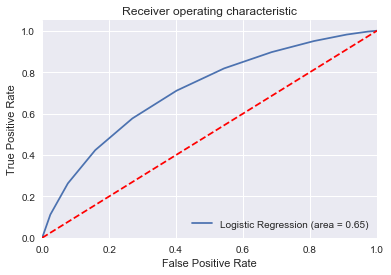

In [47]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, rf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [48]:
roc_auc_score(y_test, y_pred_rf)

0.65457908355781624

Similarly, accuracy shows low gain of data from the chosen criterion, the data can't handle mix of binary and continuous to give accuracy score.

## Model 4: LightGBM Model

In [50]:
import lightgbm as lgb
mdl =lgb.LGBMClassifier(boosting_type ='gbdt',objective ='binary', num_leaves =30)
mdl.fit(X_train,y_train)

/Users/Gary/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/Gary/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=30, objective='binary', random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)

In [51]:
# Use the forest's predict method on the test data
y_pred_mdl = mdl.predict(X_test)
y_train_pred_mdl=mdl.predict(X_train)
print("Accuracy of logistic regression classifier on on test set: {:0.5f}".format(mdl.score(X_test, y_test)))

Accuracy of logistic regression classifier on on test set: 0.69703


In [52]:
y_train_pred_mdl

array([0, 1, 0, ..., 1, 1, 1])

In [53]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_mdl))

             precision    recall  f1-score   support

          0       0.65      0.52      0.58     82860
          1       0.72      0.81      0.76    124766

avg / total       0.69      0.70      0.69    207626



In [54]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred_mdl)
print(confusion_matrix)

[[ 43220  39640]
 [ 23264 101502]]


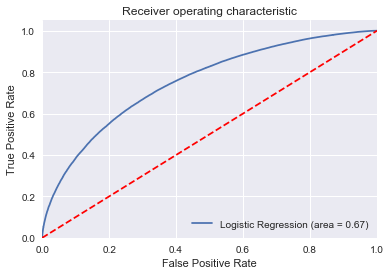

In [55]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, mdl.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, mdl.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [56]:
roc_auc_score(y_test, y_pred_mdl)

0.66757082412995938

# Section E: Model Tuning using GridSearchCV

In [57]:
X_reduced =X_train[X_train.columns[6:]]
X_reduced.info()
X_reduced.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 830500 entries, 791751 to 1012049
Data columns (total 6 columns):
purchase_count          830500 non-null int64
reordered_count         830500 non-null int64
prod_reorder_rate       830500 non-null float64
avg_days_prior_order    830500 non-null int64
avg_user_cart_size      830500 non-null int64
total_order_per_user    830500 non-null int64
dtypes: float64(1), int64(5)
memory usage: 44.4 MB


,purchase_count,reordered_count,prod_reorder_rate,avg_days_prior_order,avg_user_cart_size,total_order_per_user
791751,9959,5769,0.579275,7,14,8
857615,72846,53406,0.733136,8,52,9
207814,562,182,0.323843,3,1,4
505706,2430,1563,0.643210,4,16,5
595159,321,167,0.520249,4,63,5


In [58]:
from sklearn.model_selection import GridSearchCV

# Setup the hyperparameter grid
#,'max_depth':[4,6,8,10]
param_grid = {'learning_rate': [0.05,0.1],'num_leaves': [40,60,80]}

In [60]:
# Instantiate a lgb classifier: lgb
lgb_mdl = lgb.LGBMClassifier(boosting_type= 'gbdt', 
          objective = 'binary')


In [61]:
# Instantiate the GridSearchCV object: logreg_cv
lgb_cv = GridSearchCV(lgb_mdl, param_grid,verbose=1, cv=5, n_jobs=-1)# Fit it to the data

In [62]:
lgb_cv.fit(X_reduced.values,y_train.values.flatten())

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.9min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective='binary', random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'num_leaves': [40, 60, 80], 'learning_rate': [0.05, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [63]:
# Print the tuned parameters and score
print(lgb_cv.best_params_)
print(lgb_cv.best_score_)

{'num_leaves': 80, 'learning_rate': 0.1}
0.696646598435


# Tuning the best prediction model (LGBoost)

In [64]:
import lightgbm as lgb
mdl =lgb.LGBMClassifier(boosting_type ='gbdt',objective ='binary', num_leaves =80, learning_rate =0.1)
mdl.fit(X_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective='binary', random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)

In [65]:
# Use the forest's predict method on the test data
y_pred_mdl = mdl.predict(X_test)
y_train_pred_mdl=mdl.predict(X_train)
print("Accuracy of logistic regression classifier on on test set: {:0.5f}".format(mdl.score(X_test, y_test)))

Accuracy of logistic regression classifier on on test set: 0.69792


In [66]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_mdl))

             precision    recall  f1-score   support

          0       0.65      0.52      0.58     82860
          1       0.72      0.81      0.76    124766

avg / total       0.69      0.70      0.69    207626



In [67]:
roc_auc_score(y_test, y_pred_mdl)

0.66882295871242925

# Section F: Finding imbalanced dataset

## Aplying SMOTE to see balanced dataset

- https://elitedatascience.com/imbalanced-classes
- http://contrib.scikit-learn.org/imbalanced-learn/stable/install.html


In [94]:
pd.crosstab(
    pd.Series(y_test,name='Actual'),
    pd.Series(y_pred_lgr,name='Predicted'),
    margins=True
)

Predicted,0,1,All
Actual,,,
"(r, e, o, r, d, e, r, e, d)",47143,160483,207626
All,47143,160483,207626


/Users/Gary/anaconda/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-03-05 23:27:06.709514. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


Automatically created module for IPython interactive environment


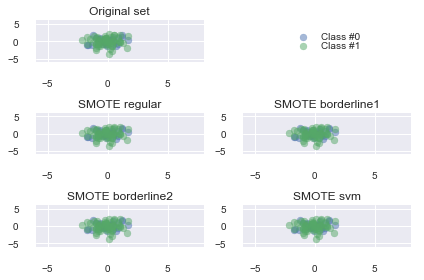

/Users/Gary/anaconda/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-03-05 23:26:03.955756. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [90]:
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE

print(__doc__)


def plot_resampling(ax, X_train, y_train, title):
    c0 = ax.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5)
    c1 = ax.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5)
    ax.set_title(title)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([-6, 8])
    ax.set_ylim([-6, 6])

    return c0, c1


# Generate the dataset
X_train, y_train = make_classification(n_classes=2, class_sep=2, weights=[0.3, 0.7],
                           n_informative=3, n_redundant=1, flip_y=0,
                           n_features=20, n_clusters_per_class=1,
                           n_samples=80, random_state=10)

# Instanciate a PCA object for the sake of easy visualisation
pca = PCA(n_components=2)
# Fit and transform x to visualise inside a 2D feature space
X_vis = pca.fit_transform(X_train)

# Apply regular SMOTE
kind = ['regular', 'borderline1', 'borderline2', 'svm']
sm = [SMOTE(kind=k) for k in kind]
X_resampled = []
y_resampled = []
X_res_vis = []
for method in sm:
    X_res, y_res = method.fit_sample(X_train, y_train)
    X_resampled.append(X_res)
    y_resampled.append(y_res)
    X_res_vis.append(pca.transform(X_res))

# Two subplots, unpack the axes array immediately
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2)
# Remove axis for second plot
ax2.axis('off')
ax_res = [ax3, ax4, ax5, ax6]

c0, c1 = plot_resampling(ax1, X_vis, y_train, 'Original set')
for i in range(len(kind)):
    plot_resampling(ax_res[i], X_res_vis[i], y_resampled[i],
                    'SMOTE {}'.format(kind[i]))

ax2.legend((c0, c1), ('Class #0', 'Class #1'), loc='center',
           ncol=1, labelspacing=0.)
plt.tight_layout()
plt.show()


Since the values of 1 in reorder ratio is more than 0, there is a down sampling imbalanced dataset existing in the results that may affect obtaining the right reorder ratio, so to reduce the majority, SMOTE is applied.

# Section G: Submitting Result to Kaggle

In [103]:
test_orders=orders[orders['eval_set']=='test']
test_orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
38,2774568,3,test,13,5,15,11.0
44,329954,4,test,6,3,12,30.0
53,1528013,6,test,4,3,16,22.0
96,1376945,11,test,8,6,11,8.0
102,1356845,12,test,6,1,20,30.0


/Users/Gary/anaconda/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-03-05 23:37:33.286654. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [132]:
prods_user2 =pd.merge(priors_product_purchase_spec,priors_product_reordered_spec,how="outer")
prods_user2['reorder_ratio']=prods_user2['reordered_count_spec']/prods_user2['purchase_count_spec']
prods_user2.head()

,user_id,product_id,purchase_count_spec,userprod_id,reordered_count_spec,reorder_ratio
0,1,196,10,100196,9.0,0.900000
1,1,10258,9,110258,8.0,0.888889
2,1,10326,1,110326,NaN,NaN
3,1,12427,10,112427,9.0,0.900000
4,1,13032,3,113032,2.0,0.666667


/Users/Gary/anaconda/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-03-06 00:56:31.702110. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [133]:
prods_user2=prods_user2.fillna(0)
test_orders_prod3=pd.merge(test_orders,prods_user2, on='user_id')
test_orders_prod3.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,purchase_count_spec,userprod_id,reordered_count_spec,reorder_ratio
0,2774568,3,test,13,5,15,11.0,248,1,300248,0.0,0.000000
1,2774568,3,test,13,5,15,11.0,1005,1,301005,0.0,0.000000
2,2774568,3,test,13,5,15,11.0,1819,3,301819,2.0,0.666667
3,2774568,3,test,13,5,15,11.0,7503,1,307503,0.0,0.000000
4,2774568,3,test,13,5,15,11.0,8021,1,308021,0.0,0.000000


/Users/Gary/anaconda/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-03-06 01:09:02.795984. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [135]:
test_orders_prodfill=pd.merge(test_orders_prod3,prods, on='product_id')
test_orders_prodfill.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,purchase_count_spec,userprod_id,reordered_count_spec,reorder_ratio,purchase_count,reordered_count,prod_reorder_rate
0,2774568,3,test,13,5,15,11.0,248,1,300248,0.0,0.000000,6371,2550,0.400251
1,1356845,12,test,6,1,20,30.0,248,1,1200248,0.0,0.000000,6371,2550,0.400251
2,3073553,418,test,9,6,17,13.0,248,1,41800248,0.0,0.000000,6371,2550,0.400251
3,1490499,503,test,37,1,16,8.0,248,1,50300248,0.0,0.000000,6371,2550,0.400251
4,391588,720,test,24,1,13,19.0,248,3,72000248,2.0,0.666667,6371,2550,0.400251


/Users/Gary/anaconda/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-03-06 01:12:36.634295. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [141]:
columns2=['eval_set','purchase_count_spec','reordered_count_spec']
test_orders_prodfill.drop(columns2, inplace=True, axis=1)

/Users/Gary/anaconda/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-03-06 01:18:39.013980. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [143]:
test_orders_prodfill.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,userprod_id,reorder_ratio,purchase_count,reordered_count,prod_reorder_rate
0,2774568,3,13,5,15,11.0,248,300248,0.000000,6371,2550,0.400251
1,1356845,12,6,1,20,30.0,248,1200248,0.000000,6371,2550,0.400251
2,3073553,418,9,6,17,13.0,248,41800248,0.000000,6371,2550,0.400251
3,1490499,503,37,1,16,8.0,248,50300248,0.000000,6371,2550,0.400251
4,391588,720,24,1,13,19.0,248,72000248,0.666667,6371,2550,0.400251


/Users/Gary/anaconda/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-03-06 01:18:47.745794. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [121]:
import lightgbm as lgb
mdl7 =lgb.LGBMClassifier(boosting_type ='gbdt',objective ='binary', num_leaves =80, learning_rate =0.1)
mdl7.fit(X_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=80, objective='binary', random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)

/Users/Gary/anaconda/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-03-06 00:34:28.546234. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [144]:
# Use the forest's predict method on the test data
y_pred_mdl7 = mdl.predict(test_orders_prodfill)

/Users/Gary/anaconda/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-03-06 01:18:51.808731. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [147]:
test_orders_prodfill['reordered']=y_pred_mdl7

/Users/Gary/anaconda/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-03-06 01:22:26.845890. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [164]:
test_orders_prodfill_final=test_orders_prodfill[test_orders_prodfill['reordered']==1]
test_orders_prodfill_final.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,userprod_id,reorder_ratio,purchase_count,reordered_count,prod_reorder_rate,reordered
0,2774568,3,13,5,15,11.0,248,300248,0.000000,6371,2550,0.400251,1
1,1356845,12,6,1,20,30.0,248,1200248,0.000000,6371,2550,0.400251,1
2,3073553,418,9,6,17,13.0,248,41800248,0.000000,6371,2550,0.400251,1
4,391588,720,24,1,13,19.0,248,72000248,0.666667,6371,2550,0.400251,1
6,1601439,1109,39,5,14,4.0,248,110900248,0.500000,6371,2550,0.400251,1


/Users/Gary/anaconda/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-03-06 01:41:46.812624. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [177]:
test_orders_prodfill_final2=test_orders_prodfill_final[['order_id','product_id']]
test_orders_prodfill_final2['products']=test_orders_prodfill_final2['product_id']
test_orders_prodfill_final2.head()

/Users/Gary/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,order_id,product_id,products
0,2774568,248,248
1,1356845,248,248
2,3073553,248,248
4,391588,248,248
6,1601439,248,248


/Users/Gary/anaconda/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-03-06 01:46:25.458869. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [178]:
test_orders_prodfill_finale=test_orders_prodfill_final2[['order_id','products']]
test_orders_prodfill_finale.head()

,order_id,products
0,2774568,248
1,1356845,248
2,3073553,248
4,391588,248
6,1601439,248


/Users/Gary/anaconda/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-03-06 01:46:50.133546. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [179]:
test_orders_prodfill_finale.to_csv("submission2.csv", encoding='utf-8',index=False)

/Users/Gary/anaconda/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-03-06 01:47:04.453751. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


# Alternative to improving results:

- Access to more features and focusing on feature importance


In [ ]:
# Checking features importance
# list of x locations for plotting
#x_values = list(range(len(trains_fe2_x)))
# Make a bar chart
#plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
#plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
#plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

[ 0.03147353  0.02288984  0.0286123   0.09155937  0.00572246  0.04148784
  0.11731044  0.02575107  0.3018598   0.          0.33333334  0.        ]


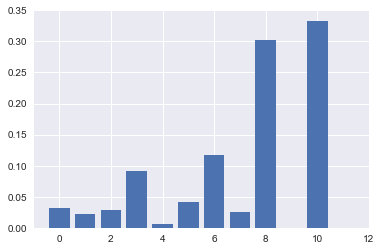

/Users/Gary/anaconda/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-03-06 01:51:12.797283. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [181]:
from numpy import loadtxt
from xgboost import XGBClassifier
from matplotlib import pyplot
# fit model no training data
xgboo = XGBClassifier()
xgboo.fit(X_train, y_train)
# feature importance
print(xgboo.feature_importances_)
# plot
pyplot.bar(range(len(xgboo.feature_importances_)), xgboo.feature_importances_)
pyplot.show()

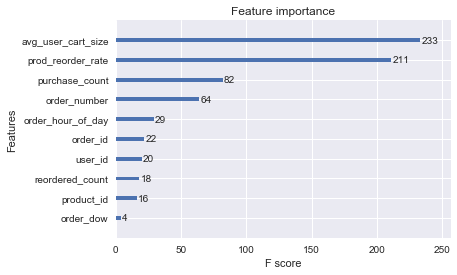

/Users/Gary/anaconda/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-03-06 19:27:58.883705. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [184]:
from xgboost import plot_importance
plot_importance(xgboo)
pyplot.show()